In [3]:
# !pip install opencv-python

In [4]:
# !pip install pyautogui

In [1]:
!pip install mediapipe

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import cv2
import pyautogui
from time import time
from math import hypot
import mediapipe as mp
import matplotlib.pyplot as plt

In [5]:
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose

# Setup the Pose function for images.
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)

# Setup the Pose function for videos.
pose_video = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)

# Initialize mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

In [7]:
def detectPose(image, pose, draw=False, display=False):
    '''
    This function performs the pose detection on the most prominent person in an image.
    Args:
        image:   The input image with a prominent person whose pose landmarks needs to be detected.
        pose:    The pose function required to perform the pose detection.
        draw:    A boolean value that is if set to true the function draw pose landmarks on the output image. 
        display: A boolean value that is if set to true the function displays the original input image, and the 
                 resultant image and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn if it was specified.
        results:      The output of the pose landmarks detection on the input image.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Check if any landmarks are detected and are specified to be drawn.
    if results.pose_landmarks and draw:
    
        # Draw Pose Landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=3, circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                                               thickness=2, circle_radius=2))

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:

        # Return the output image and the results of pose landmarks detection.
        return output_image, results

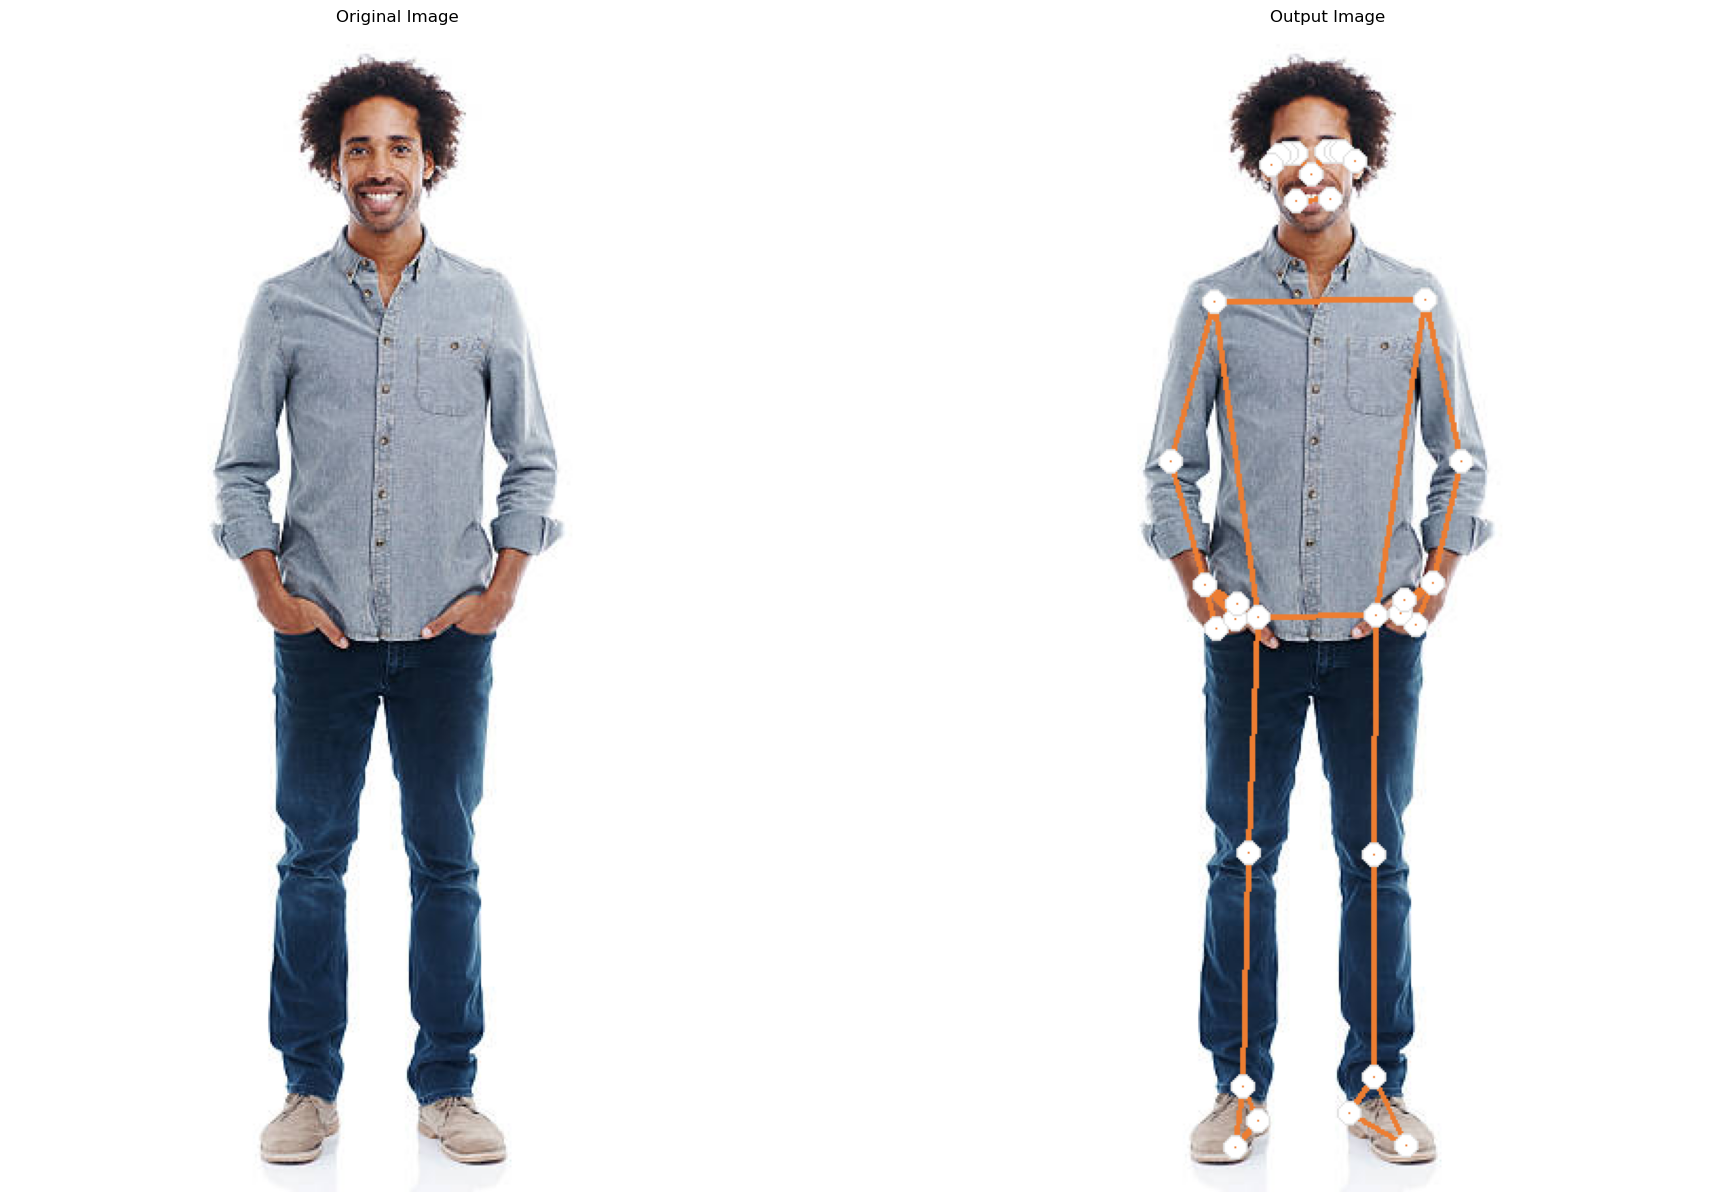

In [9]:
# Read a sample image and perform pose landmarks detection on it.
IMG_PATH = 'ps.jpg'
image = cv2.imread(IMG_PATH)
detectPose(image, pose_image, draw=True, display=True)

In [11]:
def checkHandsJoined(image, results, draw=False, display=False):
    '''
    This function checks whether the hands of the person are joined or not in an image.
    Args:
        image:   The input image with a prominent person whose hands status (joined or not) needs to be classified.
        results: The output of the pose landmarks detection on the input image.
        draw:    A boolean value that is if set to true the function writes the hands status & distance on the output image. 
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image: The same input image but with the classified hands status written, if it was specified.
        hand_status:  The classified status of the hands whether they are joined or not.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the hands status label on.
    output_image = image.copy()
    
    # Get the left wrist landmark x and y coordinates.
    left_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * width,
                          results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * height)

    # Get the right wrist landmark x and y coordinates.
    right_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * width,
                           results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * height)
    
    # Calculate the euclidean distance between the left and right wrist.
    euclidean_distance = int(hypot(left_wrist_landmark[0] - right_wrist_landmark[0],
                                   left_wrist_landmark[1] - right_wrist_landmark[1]))
    
    # Compare the distance between the wrists with a appropriate threshold to check if both hands are joined.
    if euclidean_distance < 130:
        
        # Set the hands status to joined.
        hand_status = 'Hands Joined'
        
        # Set the color value to green.
        color = (0, 255, 0)
        
    # Otherwise.    
    else:
        
        # Set the hands status to not joined.
        hand_status = 'Hands Not Joined'
        
        # Set the color value to red.
        color = (0, 0, 255)
        
    # Check if the Hands Joined status and hands distance are specified to be written on the output image.
    if draw:

        # Write the classified hands status on the image. 
        cv2.putText(output_image, hand_status, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 3)
        
        # Write the the distance between the wrists on the image. 
        cv2.putText(output_image, f'Distance: {euclidean_distance}', (10, 70),
                    cv2.FONT_HERSHEY_PLAIN, 2, color, 3)
        
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
    
        # Return the output image and the classified hands status indicating whether the hands are joined or not.
        return output_image, hand_status
# Now we will test the function checkHandsJoined() created above on a real-time webcam feed to check whether it is working as we had expected or not.

In [13]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Hands Joined?', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=True)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
            
        # Check if the left and right hands are joined.
        frame, _ = checkHandsJoined(frame, results, draw=True)
                
    # Display the frame.
    cv2.imshow('Hands Joined?', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

In [15]:
def checkLeftRight(image, results, draw=False, display=False):
    '''
    This function finds the horizontal position (left, center, right) of the person in an image.
    Args:
        image:   The input image with a prominent person whose the horizontal position needs to be found.
        results: The output of the pose landmarks detection on the input image.
        draw:    A boolean value that is if set to true the function writes the horizontal position on the output image. 
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image:         The same input image but with the horizontal position written, if it was specified.
        horizontal_position:  The horizontal position (left, center, right) of the person in the input image.
    '''
    
    # Declare a variable to store the horizontal position (left, center, right) of the person.
    horizontal_position = None
    
    # Get the height and width of the image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the horizontal position on.
    output_image = image.copy()
    
    # Retreive the x-coordinate of the left shoulder landmark.
    left_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * width)

    # Retreive the x-corrdinate of the right shoulder landmark.
    right_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * width)
    
    # Check if the person is at left that is when both shoulder landmarks x-corrdinates
    # are less than or equal to the x-corrdinate of the center of the image.
    if (right_x <= width//2 and left_x <= width//2):
        
        # Set the person's position to left.
        horizontal_position = 'Left'

    # Check if the person is at right that is when both shoulder landmarks x-corrdinates
    # are greater than or equal to the x-corrdinate of the center of the image.
    elif (right_x >= width//2 and left_x >= width//2):
        
        # Set the person's position to right.
        horizontal_position = 'Right'
    
    # Check if the person is at center that is when right shoulder landmark x-corrdinate is greater than or equal to
    # and left shoulder landmark x-corrdinate is less than or equal to the x-corrdinate of the center of the image.
    elif (right_x >= width//2 and left_x <= width//2):
        
        # Set the person's position to center.
        horizontal_position = 'Center'
        
    # Check if the person's horizontal position and a line at the center of the image is specified to be drawn.
    if draw:

        # Write the horizontal position of the person on the image. 
        cv2.putText(output_image, horizontal_position, (5, height - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
        
        # Draw a line at the center of the image.
        cv2.line(output_image, (width//2, 0), (width//2, height), (255, 255, 255), 2)
        
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
    
        # Return the output image and the person's horizontal position.
        return output_image, horizontal_position

In [17]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Horizontal Movements', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=True)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
            
        # Check the horizontal position of the person in the frame.
        frame, _ = checkLeftRight(frame, results, draw=True)
                
    # Display the frame.
    cv2.imshow('Horizontal Movements', frame)
    
    # Wait for 1ms. If a a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

In [19]:
def checkJumpCrouch(image, results, MID_Y=250, draw=False, display=False):
    '''
    This function checks the posture (Jumping, Crouching or Standing) of the person in an image.
    Args:
        image:   The input image with a prominent person whose the posture needs to be checked.
        results: The output of the pose landmarks detection on the input image.
        MID_Y:   The intial center y-coordinate of both shoulders landmarks of the person recorded during starting
                 the game. This will give the idea of the person's height when he is standing straight.
        draw:    A boolean value that is if set to true the function writes the posture on the output image. 
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image: The input image with the person's posture written, if it was specified.
        posture:      The posture (Jumping, Crouching or Standing) of the person in an image.
    '''
    
    # Get the height and width of the image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the posture label on.
    output_image = image.copy()
    
    # Retreive the y-coordinate of the left shoulder landmark.
    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * height)

    # Retreive the y-coordinate of the right shoulder landmark.
    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * height)

    # Calculate the y-coordinate of the mid-point of both shoulders.
    actual_mid_y = abs(right_y + left_y) // 2
    
    # Calculate the upper and lower bounds of the threshold.
    lower_bound = MID_Y-15
    upper_bound = MID_Y+100
    
    # Check if the person has jumped that is when the y-coordinate of the mid-point 
    # of both shoulders is less than the lower bound.
    if (actual_mid_y < lower_bound):
        
        # Set the posture to jumping.
        posture = 'Jumping'
    
    # Check if the person has crouched that is when the y-coordinate of the mid-point 
    # of both shoulders is greater than the upper bound.
    elif (actual_mid_y > upper_bound):
        
        # Set the posture to crouching.
        posture = 'Crouching'
    
    # Otherwise the person is standing and the y-coordinate of the mid-point 
    # of both shoulders is between the upper and lower bounds.    
    else:
        
        # Set the posture to Standing straight.
        posture = 'Standing'
        
    # Check if the posture and a horizontal line at the threshold is specified to be drawn.
    if draw:

        # Write the posture of the person on the image. 
        cv2.putText(output_image, posture, (5, height - 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
        
        # Draw a line at the intial center y-coordinate of the person (threshold).
        cv2.line(output_image, (0, MID_Y),(width, MID_Y),(255, 255, 255), 2)
        
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
    
        # Return the output image and posture indicating whether the person is standing straight or has jumped, or crouched.
        return output_image, posture

In [21]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Verticial Movements', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=True)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
            
        # Check the posture (jumping, crouching or standing) of the person in the frame. 
        frame, _ = checkJumpCrouch(frame, results, draw=True)
                
    # Display the frame.
    cv2.imshow('Verticial Movements', frame)
    
    # Wait for 1ms. If a a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

In [23]:
# Press the up key.
pyautogui.press(keys='up')

In [25]:
# Press the down key.
pyautogui.press(keys='down')

In [27]:
# Press the up (4 times) and down (1 time) key.
pyautogui.press(keys=['up', 'up', 'up', 'up', 'down'])

In [29]:
# Press the down key 4 times.
pyautogui.press(keys='down', presses=4)

In [35]:
# Hold down the shift key.
pyautogui.keyDown(key='shift') 

# Press the enter key two times.
pyautogui.press(keys='enter', presses=2) 

# Release the shift key.
pyautogui.keyUp(key='shift')

In [36]:
# This cell will run automatically due to keypress events in the previous cell.
print('Hello!')

Hello!


In [37]:
# This cell will also run automatically due to those keypress events.
print('Happy Learning!')

Happy Learning!


In [31]:
# Hold down the shift key.
pyautogui.keyDown(key='ctrl') 

# Press the tab key.
pyautogui.press(keys='tab') 

# Release the shift key.
pyautogui.keyUp(key='ctrl')

In [45]:
# Press the mouse right button. It will open up the menu.
pyautogui.click(button='right')

In [33]:
# Move to 1300, 800, then click the right mouse button
pyautogui.click(x=1300, y=800, button='right')

In [39]:
import webbrowser
import time

# Open the Subway Surfers game on Poki
webbrowser.open("https://poki.com/en/g/subway-surfers")

# Wait for the game to load
time.sleep(8)


In [41]:
import time

# Assume pose_video, detectPose, checkLeftRight, checkHandsJoined, and checkJumpCrouch are defined above this cell.

camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window and force it to stay on top and resized.
cv2.namedWindow('Subway Surfers with Pose Detection', cv2.WINDOW_NORMAL)
cv2.setWindowProperty('Subway Surfers with Pose Detection', cv2.WND_PROP_TOPMOST, 1)
cv2.resizeWindow('Subway Surfers with Pose Detection', 640, 480)
cv2.moveWindow('Subway Surfers with Pose Detection', 100, 100)

time1 = 0
game_started = False
x_pos_index = 1
y_pos_index = 1
MID_Y = None
counter = 0
num_of_frames = 10

while camera_video.isOpened():
    ok, frame = camera_video.read()
    if not ok:
        continue

    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape

    frame, results = detectPose(frame, pose_video, draw=game_started)

    if results.pose_landmarks:
        if game_started:
            frame, horizontal_position = checkLeftRight(frame, results, draw=True)

            if (horizontal_position == 'Left' and x_pos_index != 0) or (horizontal_position == 'Center' and x_pos_index == 2):
                pyautogui.press('left')
                x_pos_index -= 1

            elif (horizontal_position == 'Right' and x_pos_index != 2) or (horizontal_position == 'Center' and x_pos_index == 0):
                pyautogui.press('right')
                x_pos_index += 1
        else:
            cv2.putText(frame, 'JOIN BOTH HANDS TO START THE GAME.', (5, frame_height - 10), cv2.FONT_HERSHEY_PLAIN,
                        2, (0, 255, 0), 3)

        if checkHandsJoined(frame, results)[1] == 'Hands Joined':
            counter += 1
            if counter == num_of_frames:
                if not game_started:
                    game_started = True

                    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * frame_height)
                    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * frame_height)
                    MID_Y = abs(right_y + left_y) // 2

                    # Instead of clicking (which might fullscreen), just press space to start
                    pyautogui.press('space')
                else:
                    pyautogui.press('space')
                counter = 0
        else:
            counter = 0

        if MID_Y:
            frame, posture = checkJumpCrouch(frame, results, MID_Y, draw=True)
            if posture == 'Jumping' and y_pos_index == 1:
                pyautogui.press('up')
                y_pos_index += 1
            elif posture == 'Crouching' and y_pos_index == 1:
                pyautogui.press('down')
                y_pos_index -= 1
            elif posture == 'Standing' and y_pos_index != 1:
                y_pos_index = 1
    else:
        counter = 0

    time2 = time.time()
    if (time2 - time1) > 0:
        fps = 1.0 / (time2 - time1)
        cv2.putText(frame, 'FPS: {}'.format(int(fps)), (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    time1 = time2

    cv2.imshow('Subway Surfers with Pose Detection', frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

camera_video.release()
cv2.destroyAllWindows()
